In [4]:
# album_blur.ipynb
# Created 8-25-19 by Eric Graves
# See spotify_album_blur.md for more information

In [39]:
# Imports and environment setup
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
import math
import scipy
import scipy.cluster
import scipy.misc
import binascii
%matplotlib inline

# DEBUG shows input and output images, DEBUG_VERBOSE shows images and sizes at each step
DEBUG = True
DEBUG_VERBOSE = True
if not DEBUG :
    DEBUG_VERBOSE = False # Can only be enabled in DEBUG mode

# This parameter sets how much the image is scaled before processing: 
#-- Smaller image ==> more loss, but faster processing
#-- Just divides the image dimensions in pixels, good values are between 1 and 10. Any smaller and there is a lot of loss of detail/accent colors.
IMAGE_SCALE = 5 
    
# The number of clusters for image color processing
NUM_CLUSTERS = 5
    
# Test image name
TEST_IMAGE = 'IMG_3725_ART.PNG'# Brockhampton Saturation III album art 

(591, 590, 4)


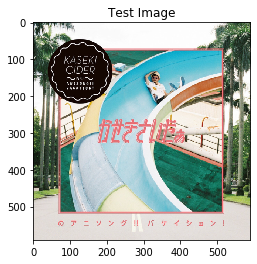

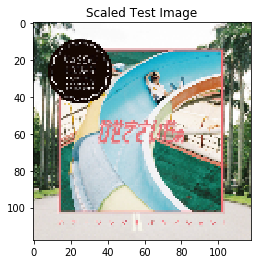

codes is of length 5
counts [1773 2733 1376 6725 1317] 
bins [0.  0.8 1.6 2.4 3.2 4. ]
second is [221. 158. 173. ... 255. 255. 255.]
most frequent is [227.02225519 227.04065282 224.07195846 255.        ] (#e3e3e0ff)


TypeError: not enough arguments for format string

In [50]:
# Read image, set size
img = plt.imread(TEST_IMAGE, 0)
img_PIL = Image.open(TEST_IMAGE) 
h,w = img.shape[:2]
if DEBUG_VERBOSE :
    print(img.shape)
    plt.imshow(img) 
    plt.title("Test Image")
    plt.show()
    
# Resize the image for faster processing time
#-- there is noticable loss of color detail in thin lines on the artwork, as expected, but in order to save the accent colors scaling must be minimized.
img_resized = img_PIL.resize(((int)(h/IMAGE_SCALE), (int)(w/IMAGE_SCALE)))
if DEBUG_VERBOSE :
    plt.imshow(img_resized) 
    plt.title("Scaled Test Image")
    plt.show()
    
# Open PIL Image as array for cluster processing
# Code modified from: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
img_as_array = np.asarray(img_resized)

shape = img_as_array.shape # reshape to 2 dims
img_as_array = img_as_array.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

codes, dist = scipy.cluster.vq.kmeans(img_as_array, NUM_CLUSTERS)
print('codes is of length', len(codes))

vecs, dist = scipy.cluster.vq.vq(img_as_array, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences
print('counts', counts, '\nbins', bins)

index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]

index_sec = np.partition(img_as_array.flatten(), -2)       # find 2nd most frequent
#peak_sec = codes[index_sec]
print('second is %s' % index_sec)

color_max = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
print('most frequent is %s (#%s)' % (peak, color_max))

color_sec = binascii.hexlify(bytearray(int(c) for c in index_sec)).decode('ascii')
print('second is %s (#%s)' % (index_sec, color_sec))

# Display most frequent color (we dont usually want this one, since Spotify uses the accent color)


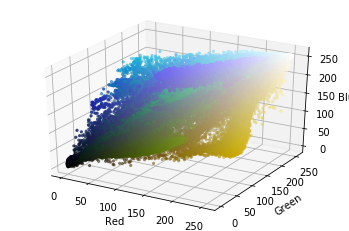

In [5]:
# Visualize image color components
# Not needed in production, but useful to debug image thresholds
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

vis_img = cv.imread(TEST_IMAGE) # Change to test different images

r, g, b = cv.split(vis_img)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = vis_img.reshape((np.shape(vis_img)[0]*np.shape(vis_img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

In [ ]:
# Code from: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
# bonus: save image using only the N most common colours
import imageio
c = ar.copy()
for i, code in enumerate(codes):
    c[scipy.r_[scipy.where(vecs==i)],:] = code
imageio.imwrite('clusters.png', c.reshape(*shape).astype(np.uint8))
print('saved clustered image')